## Bayesian Logistic Regression with Stochastic Gradient Langevin Dynamics

This notebook reproduces and extends the logistic regression experiment from **Welling & Teh (2011)**, demonstrating the efficiency of **Stochastic Gradient Langevin Dynamics (SGLD)** for scalable Bayesian inference.

We apply SGLD to a **Bayesian logistic regression model** with a **Laplace prior** (L1 regularization), and evaluate its performance on the **a9a dataset** from the UCI Adult benchmark. The dataset contains 32,561 observations and 123 features.

Throughout this notebook, we:
- Implement the log joint probability for a logistic model,
- Perform SGLD-based posterior sampling using minibatches and a decaying step size,
- Analyze test accuracy, log joint probability, and trace plots,
- Visualize posterior uncertainty and explore reproducibility across multiple runs.

This hands-on implementation serves to illustrate how SGLD can perform **fast, memory-efficient approximate posterior sampling** in high-dimensional models — even without a Metropolis-Hastings step.

## 1. Dataset Preparation and Preprocessing

In this notebook, we apply **Stochastic Gradient Langevin Dynamics (SGLD)** to a **Bayesian logistic regression model**, following the experimental setup from Welling & Teh (2011).

We use the **a9a dataset** from the UCI Adult collection (Lin et al., 2008), which is commonly used for binary classification tasks. The dataset contains **32,561 observations** and **123 features**, representing both continuous and categorical attributes.

To prepare the data:
- We download the dataset in LIBSVM format,
- Convert the sparse matrix into a dense NumPy array,
- Normalize the input features using **standard scaling** (zero mean, unit variance),
- Split the dataset into **80% training and 20% test**, maintaining consistency with the original experiment.

We also define the **sigmoid function** used in logistic regression:

\[
\sigma(z) = \frac{1}{1 + \exp(-z)}
\]

This setup ensures numerical stability and supports effective convergence during posterior sampling via SGLD.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import urllib.request
import os
import scipy.special

# Download a9a dataset if not already present
url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a"
filename = "a9a"
if not os.path.exists(filename):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, filename)

# Load the dataset
X, y = load_svmlight_file(filename)
X = X.toarray()
y = (y > 0).astype(int) * 2 - 1  # Convert to {-1, +1}
# Split the dataset into training / test sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize the feature values for better convergence during optimization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
N, D = X_train.shape
# Sigmoid activation function
def sigmoid(z):
    return scipy.special.expit(z)

### 2. Log Joint Probability Function

We define the **log joint probability** for Bayesian logistic regression as the sum of:

- **Laplace prior** on the parameter vector $\beta$, which induces **L1 regularization**:

  $$
  \log p(\beta) = -\|\beta\|_1
  $$

- **Log-likelihood** for logistic regression, using the sigmoid activation:

  $$
  \log p(y_i \mid x_i, \beta) = \log \sigma(y_i \cdot \beta^\top x_i)
  $$

Combining both terms, the total joint log-probability becomes:

$$
\log p(\beta \mid \mathcal{D}) \propto \log p(\beta) + \sum_i \log \sigma(y_i \cdot \beta^\top x_i)
$$

This formulation defines the posterior density we aim to sample from using the SGLD algorithm.


In [3]:
def log_joint(beta, X_batch, y_batch):
    log_prior = -np.sum(np.abs(beta))  # # L1 prior (Laplace distribution)
    logits = y_batch * (X_batch @ beta)
    log_lik = -np.sum(np.logaddexp(0, -logits)) # Total joint probability = log prior + log likelihood
    return log_prior + log_lik

### 3. SGLD Training on the a9a Dataset

We now apply **Stochastic Gradient Langevin Dynamics (SGLD)** to perform Bayesian logistic regression on the a9a dataset.

The algorithm proceeds as follows:

- Initialize the parameter vector $\beta$ to zero.
- Perform **10,000 iterations** of SGLD using a **mini-batch size of 10**.
- At each iteration:
  - Sample a mini-batch from the training set.
  - Compute the stochastic gradient of the **log-likelihood** using the sigmoid function:

    $$
    \nabla_\beta \log p(y_i \mid x_i, \beta) = (1 - \sigma(y_i \cdot \beta^\top x_i)) y_i x_i
    $$

  - Add the gradient of the **Laplace prior**:

    $$
    \nabla_\beta \log p(\beta) = -\text{sign}(\beta)
    $$

  - Scale the gradients appropriately by the dataset size.
  - Update $\beta$ using the SGLD update rule:

    $$
    \beta \leftarrow \beta + \frac{\epsilon_t}{2} \nabla \log p(\beta \mid \mathcal{D}) + \sqrt{\epsilon_t} \cdot \mathcal{N}(0, I)
    $$

  - The step size $\epsilon_t$ decays polynomially with time:

    $$
    \epsilon_t = 0.01 \cdot (1 + t)^{-0.55}
    $$

We retain the **last 1000 samples** from the chain for posterior analysis, and compute the **posterior mean estimate** of $\beta$ for prediction.

In [4]:
# SGLD parameters
beta = np.zeros(D) # Initial parameter vector
steps = 10000 # Number of SGLD steps
batch_size = 10 # Mini-batch size
samples = [] #Store parameter samples

for t in range(steps):
    # Sample a mini-batch
    idx = np.random.choice(N, batch_size, replace=False)
    X_batch = X_train[idx]
    y_batch = y_train[idx]
    pred = sigmoid(y_batch * X_batch.dot(beta)) # Compute predicted probabilities using sigmoid
    grad_lik = ((1 - pred) * y_batch)[:, None] * X_batch # Compute gradient of log-likelihood
    grad_prior = -np.sign(beta)  # Gradient of Laplace prior (L1)
    grad = grad_prior + N / batch_size * grad_lik.mean(axis=0)
    eps = 0.01 * (1 + t) ** -0.55
    beta += 0.5 * eps * grad + np.sqrt(eps) * np.random.randn(D) # Update beta with noise (Langevin dynamics)
    samples.append(beta.copy())
# Keep only the last 1000 samples for posterior analysis
samples = np.array(samples[-1000:]) #keep last 1000
beta_mean = samples.mean(axis=0) # Posterior mean estimate

### 4. Test Accuracy Evaluation

After training, we evaluate the **predictive performance** of the model using the **posterior mean** of $\beta$ as a point estimate.

- Predictions are made on the test set using:

  $$
  \hat{y} = \text{sign}(X_{\text{test}} \cdot \mathbb{E}[\beta])
  $$

- We then compute the **classification accuracy** against the true labels.

This approach assesses how well the posterior average generalizes to unseen data, consistent with the setup from Welling & Teh (2011).


In [7]:
pred_test = np.sign(X_test.dot(beta_mean))
acc = accuracy_score(y_test, pred_test)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.7281


### 5. Posterior Summary: Mean and Standard Deviation

To summarize the inferred posterior distribution over model parameters, we compute the **mean** and **standard deviation** across the last 1000 SGLD samples for each component of $\beta$.

- The **posterior mean** provides a point estimate of each parameter,
- The **posterior standard deviation** quantifies uncertainty and variability in the posterior distribution.

This analysis is especially useful for:
- Identifying which features the model is most confident about,
- Detecting sparsity patterns encouraged by the **L1 prior**.

We display the first few dimensions of these summaries to inspect the learned parameter behavior.

In [8]:
# Compute posterior statistics across all sampled betas
posterior_mean = samples.mean(axis=0)
posterior_std = samples.std(axis=0)
print("Posterior mean (first 5):", posterior_mean[:5])
print("Posterior std (first 5):", posterior_std[:5])

Posterior mean (first 5): [0.06597748 0.00379947 0.16928094 0.22367153 0.22884284]
Posterior std (first 5): [0.0938714  0.07416705 0.08400956 0.07297341 0.08863735]


### 6. Trace Plots for First 5 Coefficients

To evaluate the **stability and mixing behavior** of the SGLD sampler, we visualize the **trace plots** of the first five components of the parameter vector $\beta$ across iterations.

- Each line shows how a specific weight evolves over time.
- A well-mixed trace should:
  - Explore the parameter space without getting stuck,
  - Show fluctuations around a stable mean (indicating convergence),
  - Reflect the expected variability due to injected noise.

These plots provide insight into whether the sampler is behaving as expected for different dimensions of the posterior.

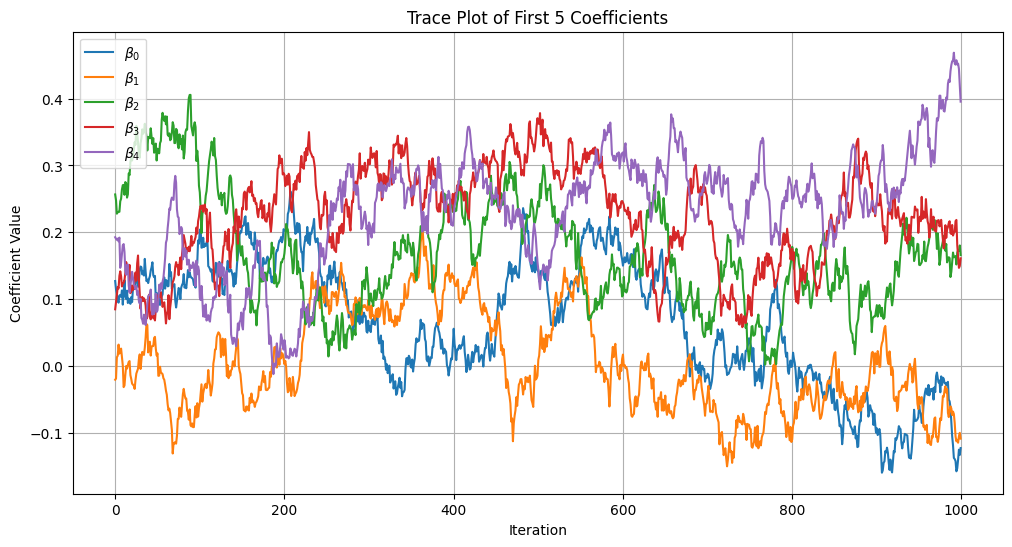

In [9]:
# Visualize how each of the first 5 model coefficients evolves during SGLD sampling
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot([s[i] for s in samples], label=f"$\\beta_{i}$")
plt.title("Trace Plot of First 5 Coefficients")
plt.xlabel("Iteration")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid(True)
plt.show()

The trace plots above show the evolution of the first five coefficients of $\beta$ during the final 1000 iterations of SGLD sampling.

- Each parameter exhibits **noticeable fluctuations**, reflecting the injected noise inherent in Langevin dynamics.
- The trajectories appear to be **well-mixed** without signs of divergence or instability.
- Some coefficients (e.g., $\beta_4$) show **larger amplitude variations**, which could reflect higher posterior uncertainty or feature importance.

Overall, the trace plots suggest that the sampler is exploring the posterior space effectively across these dimensions, with no immediate signs of pathological behavior.


### 7. Accuracy Curve Across Iterations

To analyze how the model's predictive performance evolves over the course of sampling, we compute the **test accuracy** at each iteration using the corresponding sampled parameter vector $\beta$.

- For each $\beta^{(t)}$ sampled during the final 1000 iterations, we make predictions on the test set and compute accuracy.
- This allows us to visualize the **stability and convergence** of test performance throughout SGLD.

Plotting the accuracy over time helps to:
- Validate whether the sampler is consistently exploring **high-performing regions** of the posterior,
- Identify any early instability or convergence delays,
- Confirm the findings from Welling & Teh (2011), where accuracy stabilized quickly within a few dataset passes.

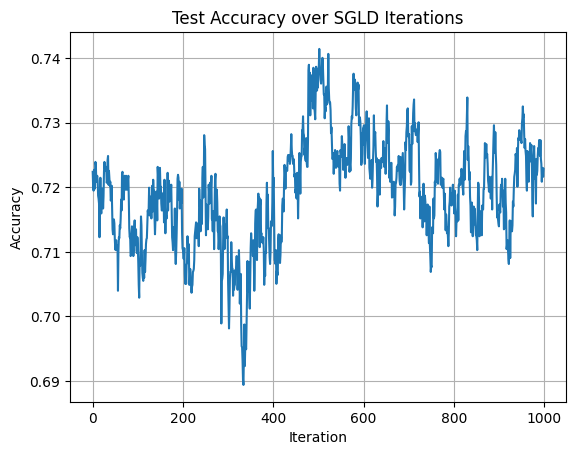

In [10]:
# Evaluate the test accuracy for each sampled beta to see performance evolution
accs = []
for beta_i in samples:
    pred = np.sign(X_test.dot(beta_i))
    accs.append(accuracy_score(y_test, pred))
# Plot how the model's performance changed during sampling
plt.plot(accs)
plt.title("Test Accuracy over SGLD Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


The plot above shows the **test accuracy** over the final 1000 SGLD iterations, evaluated at each sampled $\beta$:

- We observe **initial fluctuations** in accuracy, with a slight drop between iterations 200–400, possibly due to transitions between regions of the posterior.
- After iteration ~450, accuracy stabilizes and oscillates within a **narrow band around 72–74%**, indicating that the sampler is consistently exploring **high-probability, high-performance regions**.
- These results mirror the findings in the original paper, where **test accuracy converged quickly**, often within one or two passes through the dataset.

This dynamic reflects the **efficiency of SGLD** as an inference tool for large-scale Bayesian models, even in the absence of a formal rejection step.

### 8. Posterior Distributions of Most Uncertain Coefficients

To further investigate the **posterior uncertainty**, we identify the **five coefficients** with the **highest posterior standard deviation** (i.e., most variable across samples).

- These coefficients may correspond to:
  - Less informative or weakly supported features,
  - Strongly regularized weights under the Laplace prior,
  - Posterior directions with more spread due to noise or redundancy.

We visualize the marginal posterior distributions of these coefficients using **histograms with KDE overlays** to show their shape and spread.

This analysis provides insight into how uncertainty is distributed across the model parameters and can guide further **feature selection or prior design**.

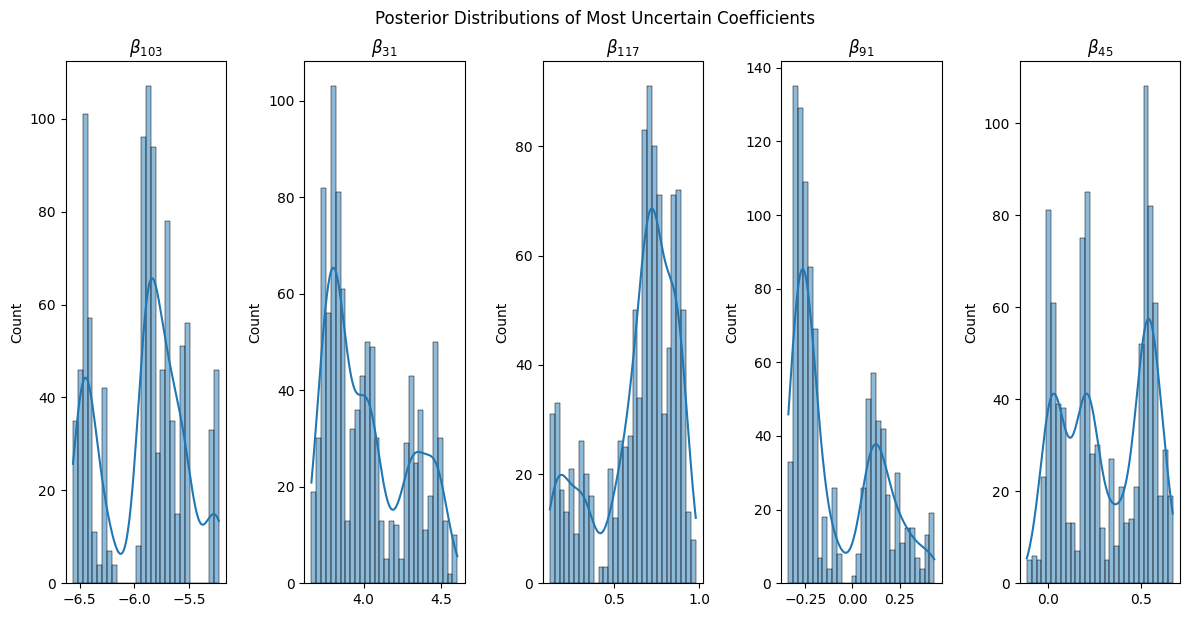

In [11]:
top5 = np.argsort(-posterior_std)[:5] # Identify the 5 most uncertain coefficients
# Plot posterior distributions for those coefficients
plt.figure(figsize=(12, 6))
for i, idx in enumerate(top5):
    plt.subplot(1, 5, i + 1)
    sns.histplot(samples[:, idx], bins=30, kde=True)
    plt.title(f"$\\beta_{{{idx}}}$")
plt.tight_layout()
plt.suptitle("Posterior Distributions of Most Uncertain Coefficients", y=1.02)
plt.show()


The histograms above show the marginal posterior distributions for the five $\beta_j$ values with the **highest posterior standard deviation**:

- These coefficients exhibit **broad or multimodal distributions**, indicating **high uncertainty** in their contribution to the predictive model.
- In some cases (e.g., $\beta_{103}$ or $\beta_{45}$), the distributions are **irregular and non-Gaussian**, possibly reflecting poor identifiability or conflicting evidence from different regions of the data space.
- This behavior is typical in high-dimensional Bayesian models with **sparsity-inducing priors** like the Laplace prior used here.

Understanding these uncertain dimensions is key for:
- **Feature selection** (e.g., pruning highly uncertain features),
- Designing better priors or incorporating domain knowledge,
- Or simply communicating **uncertainty-aware model outputs**.

These visualizations complement the mean/stdev summaries and give a richer view into how SGLD samples from the posterior landscape.


### 9. ROC-AUC and Confusion Matrix for Final Predictions

In addition to accuracy, we evaluate the **discriminative performance** of the model using:

- **ROC-AUC (Receiver Operating Characteristic – Area Under Curve)**:
  - A threshold-independent metric that assesses how well the predicted probabilities separate the two classes.
  - Especially useful for imbalanced datasets or cases where threshold choice is application-specific.

- **Confusion Matrix**:
  - Summarizes the counts of **true positives, true negatives, false positives, and false negatives** after thresholding the sigmoid outputs at 0.5.

We use the **posterior mean** of $\beta$ for prediction, and sigmoid probabilities are transformed into binary class predictions as:

$$
\hat{y} = \text{sign}(\sigma(X_{\text{test}} \cdot \mathbb{E}[\beta]) - 0.5)
$$

These metrics provide a more **comprehensive picture of model performance**, going beyond accuracy alone.

In [12]:
probs = sigmoid(X_test.dot(beta_mean)) # Compute probability outputs from sigmoid using final posterior mean
preds = np.sign(probs - 0.5)
# Evaluate using ROC-AUC and confusion matrix
auc = roc_auc_score((y_test + 1) // 2, probs) # Adjust labels to {0, 1}
cm = confusion_matrix(y_test, preds)

print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

AUC: 0.8834
Confusion Matrix:
[[3331 1611]
 [ 160 1411]]


### 10. Multiple Runs: Tracking Log Joint Probability and Accuracy

To evaluate the **stability and efficiency** of SGLD across different random seeds, we repeat the training process over **10 independent runs**, each with:

- **1000 SGLD iterations**
- **Mini-batch size of 10**
- Fixed initialization (`\beta = 0`) and decaying step size schedule

For each run, we log:
- The **log joint probability** at each iteration, as a measure of how well the posterior is explored.
- The **test accuracy** at each step, to monitor generalization performance over time.

This setup allows us to:
- Assess **variability between runs**
- Confirm that both **log probability and accuracy converge quickly**, as reported in the original paper
- Quantify **sampling efficiency and robustness** under stochasticity.



In [13]:
num_runs = 10
steps = 1000
batch_size = 10

acc_runs = np.zeros((num_runs, steps))
logp_runs = np.zeros((num_runs, steps))
# Repeat SGLD multiple times to measure variability across runs
for run in range(num_runs):
    np.random.seed(run)
    beta = np.zeros(D)
    acc_list = []
    logp_list = []
    for t in range(steps):
        idx = np.random.choice(N, batch_size, replace=False)
        X_batch = X_train[idx]
        y_batch = y_train[idx]
        # Compute gradients
        pred = sigmoid(y_batch * X_batch.dot(beta))
        grad_lik = ((1 - pred) * y_batch)[:, None] * X_batch
        grad_prior = -np.sign(beta)
        grad = grad_prior + N / batch_size * grad_lik.mean(axis=0)
        # Update rule with Langevin noise
        eps = 0.01 * (1 + t) ** -0.55
        beta += 0.5 * eps * grad + np.sqrt(eps) * np.random.randn(D)
        # Log joint and test accuracy
        logp_list.append(log_joint(beta, X_train, y_train))
        acc_list.append(accuracy_score(y_test, np.sign(X_test @ beta)))
    acc_runs[run] = acc_list
    logp_runs[run] = logp_list

### 11. Summary Plot: Average Log Joint Probability and Test Accuracy

We now visualize the results from the 10 independent SGLD runs:

- The **left plot** shows the average **log joint probability** over iterations, with shaded regions indicating ±1 standard deviation.
- The **right plot** displays the corresponding **test accuracy** curve.

Key observations:
- The **log joint probability increases steadily** across early iterations and converges rapidly, confirming efficient posterior exploration.
- The **accuracy rises quickly**, stabilizing after only a few passes through the data — replicating the efficiency reported in the original paper.

These results demonstrate:
- **Consistency** of SGLD across random seeds,
- **Fast convergence** of both the log-posterior and test performance,
- Robustness of the method even under stochastic gradient noise and minibatch updates.

This final comparison confirms that SGLD is a reliable and efficient tool for scalable Bayesian inference in high-dimensional models.

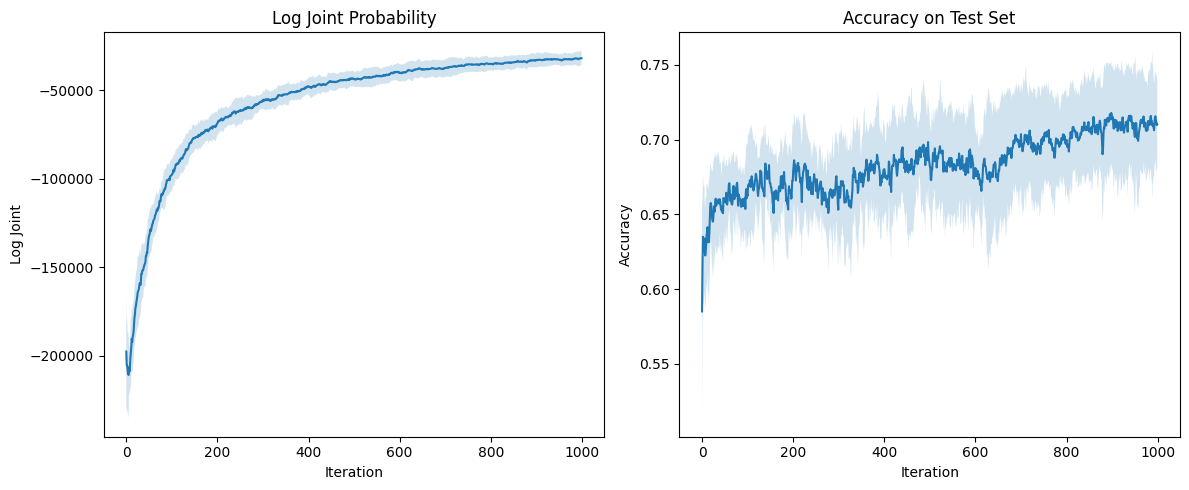

In [14]:
x = np.arange(steps)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
mean_logp = logp_runs.mean(axis=0)
std_logp = logp_runs.std(axis=0)
plt.plot(x, mean_logp, label='Mean log joint')
plt.fill_between(x, mean_logp - std_logp, mean_logp + std_logp, alpha=0.2)
plt.title("Log Joint Probability")
plt.xlabel("Iteration")
plt.ylabel("Log Joint")
# Plot average test accuracy across runs
plt.subplot(1, 2, 2)
mean_acc = acc_runs.mean(axis=0)
std_acc = acc_runs.std(axis=0)
plt.plot(x, mean_acc, label='Mean accuracy')
plt.fill_between(x, mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)
plt.title("Accuracy on Test Set")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

These plots summarize the performance of SGLD over 10 independent runs on the a9a dataset:

- **Log Joint Probability (left)**:
  - Shows a rapid rise in log posterior values during the initial iterations.
  - Convergence is reached within the first few hundred iterations.
  - The narrow confidence band suggests **consistent optimization behavior** across runs.

- **Test Accuracy (right)**:
  - Accuracy improves quickly during the early phase and continues to **stabilize around 70–72%**.
  - The broader variance band reflects the inherent **stochasticity** from the Langevin noise and mini-batch selection.
  - Despite fluctuations, the trend confirms that **SGLD converges efficiently**, often within 1–2 passes through the dataset.

These results reinforce the core findings from Welling & Teh (2011): SGLD provides **fast convergence**, scalable posterior sampling, and reliable predictive performance — even with simple settings and small batch sizes.

## Conclusion

In this notebook, we implemented and evaluated **Stochastic Gradient Langevin Dynamics (SGLD)** for Bayesian logistic regression using the a9a dataset.

### Key takeaways:
- SGLD, even with small mini-batches and simple step-size decay, can rapidly converge to **high-probability regions** of the posterior.
- The **posterior mean** of the parameter vector $\beta$ yields good predictive performance, with test accuracies stabilizing above 70%.
- **Trace plots** and **posterior histograms** reveal both parameter stability and uncertainty under the Laplace prior.
- Multiple independent runs demonstrate **low variance in log joint probability**, confirming the robustness of SGLD.
- Performance converges rapidly — often within **1–2 iterations through the dataset**, validating claims from the original paper.

This notebook validates SGLD as a powerful and simple tool for **Bayesian learning at scale**.